# Variational Autoencoder Sequence-to-Sequence Model for Speech

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))

import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Utility functions and classes


In [3]:
class SimpleIterator(object):
    
    def __init__(self, x_list, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.indices = np.arange(len(self.x_lengths))
        np.random.shuffle(self.indices)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            np.random.shuffle(self.indices)
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [4]:
class SimpleBucketIterator(object):
    
    def __init__(self, x_list, batch_size, n_buckets, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [5]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 5106
E.g. item shape: (51, 39)


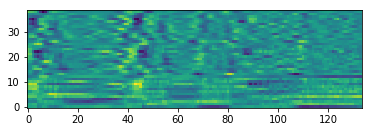

In [6]:
plt.imshow(train_x[3277].T, origin="bottom");

In [7]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [8]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
train_x_min = np.inf
train_x_max = -np.inf
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
    train_x_min = np.min(train_x[i]) if np.min(train_x[i]) < train_x_min else train_x_min
    train_x_max = np.max(train_x[i]) if np.max(train_x[i]) > train_x_max else train_x_max
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

-3.159403 3.697388


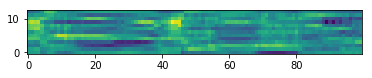

In [9]:
plt.imshow(train_x[3277].T, origin="bottom");
print(np.min(train_x[3277]), np.max(train_x[3277]))

In [10]:
# Scale training and validation to between 0 and 1
train_x_scaled = []
val_x_scaled = []
for seq in train_x:
    cur_seq = np.clip(
        (seq - train_x_min)/(train_x_max - train_x_min),
        train_x_min, train_x_max
        )
    train_x_scaled.append(cur_seq)
for seq in val_x:
    cur_seq = np.clip(
        (seq - train_x_min)/(train_x_max - train_x_min),
        train_x_min, train_x_max
        )
    val_x_scaled.append(cur_seq)

0.175464265195 0.786332038359


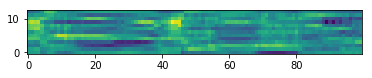

In [11]:
plt.imshow(train_x_scaled[3277].T, origin="bottom");
print(np.min(train_x_scaled[3277]), np.max(train_x_scaled[3277]))

## Sequence-to-sequence model with latent VAE representation (Gaussian)

In [10]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 10  # 50
batch_size = 100
n_buckets = 3

# Model parameters
n_input = d_frame
n_hidden = 150
build_latent_func = tflego.build_vae
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130,
    "dec_n_hiddens": [n_hidden],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
model_fn = path.join(output_dir, "lazydynamic_latent_vae.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_encdec_lazydynamic_latentfunc(
    x, x_lengths, n_hidden, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
vae = network_dict["latent_layer"]
z_mean = vae["z_mean"]
z_log_sigma_sq = vae["z_log_sigma_sq"]
z = vae["z"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# VAE loss
sigma_sq = 0.00001  # smaller values: care more about reconstruction
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = tflego.vae_loss_gaussian(x, y, sigma_sq, z_mean, z_log_sigma_sq, reconstruction_loss=reconstruction_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [11]:
np.random.seed(1)
train_batch_iterator = SimpleBucketIterator(
    train_x, batch_size, n_buckets, True
    )
val_batch_iterator = SimpleBucketIterator(
    val_x, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, x_lengths], [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-08-08 08:34:37.597537
Epoch 0:
3.981 sec, train loss: 51186.6, val loss: [  4.26157266e+04   9.71278369e-01] *
Epoch 1:
3.466 sec, train loss: 41682.0, val loss: [  4.02541328e+04   9.17454422e-01] *
Epoch 2:
3.458 sec, train loss: 39114.3, val loss: [  3.79196523e+04   8.63685310e-01] *
Epoch 3:
3.468 sec, train loss: 36830.1, val loss: [  3.65620586e+04   8.31599951e-01] *
Epoch 4:
3.458 sec, train loss: 35391.7, val loss: [  3.55036445e+04   8.06796193e-01] *
Epoch 5:
3.477 sec, train loss: 34296.9, val loss: [  3.44245859e+04   7.81805456e-01] *
Epoch 6:
3.468 sec, train loss: 33388.0, val loss: [  3.40116484e+04   7.71901071e-01] *
Epoch 7:
3.472 sec, train loss: 32561.6, val loss: [  3.31921680e+04   7.52817094e-01] *
Epoch 8:
3.473 sec, train loss: 31858.1, val loss: [  3.31216250e+04   7.50509143e-01] *
Epoch 9:
3.462 sec, train loss: 31046.8, val loss: [  3.21707988e+04   7.28698611e-01] *
Training time: 0.586 min
2018-08-08 08:35:14.728456


In [51]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/lazydynamic_latent_vae.ckpt


In [13]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.0884
Precision-recall breakeven: 0.1538


In [17]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.1001
Precision-recall breakeven: 0.1695


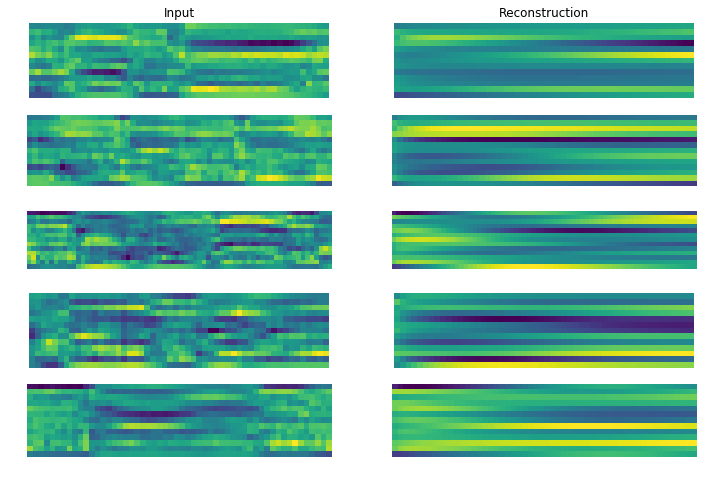

In [18]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

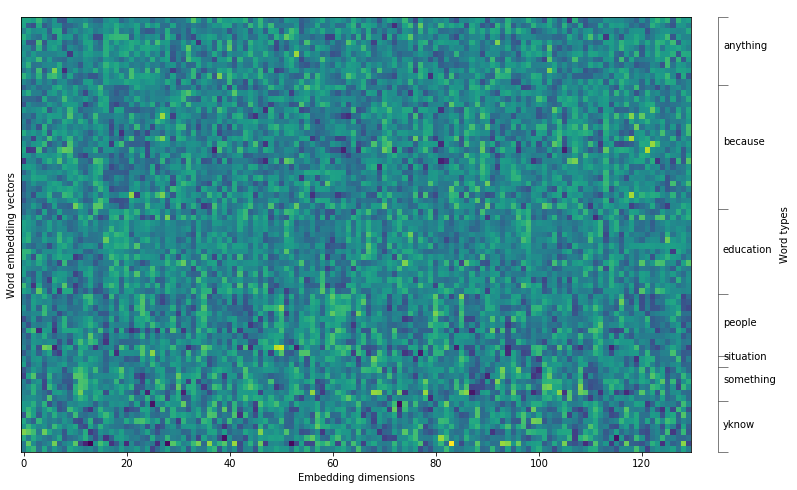

In [21]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=True, figsize=(12, 8)
    )

## Sequence-to-sequence model with latent $\beta$-VAE representation (Bernoulli)

In [19]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.0001
n_epochs = 10  # 50
batch_size = 100
n_buckets = 3

# Model parameters
n_input = d_frame
n_hidden = 150
build_latent_func = tflego.build_vae
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130,
    "dec_n_hiddens": [n_hidden],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
model_fn = path.join(output_dir, "lazydynamic_latent_beta_vae.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_encdec_lazydynamic_latentfunc(
    x, x_lengths, n_hidden, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
vae = network_dict["latent_layer"]
z_mean = vae["z_mean"]
z_log_sigma_sq = vae["z_log_sigma_sq"]
z = vae["z"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

# Bernoulli loss
y = tf.nn.sigmoid(y)
y *= tf.expand_dims(mask, -1)  # safety

# Beta-VAE loss (Bernoulli)
beta = 0.0
log_loss = x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y)
reconstruction_loss = -tf.reduce_sum(log_loss, -1)
reconstruction_loss *= mask  # safety
reconstruction_loss = tf.reduce_sum(reconstruction_loss, -1) / tf.reduce_sum(mask, 1)
reconstruction_loss = tf.reduce_mean(reconstruction_loss) # https://danijar.com/variable-sequence-lengths-in-tensorflow/
regularisation_loss = tf.reduce_mean(
    -0.5*tf.reduce_sum(
    1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
    )
loss = reconstruction_loss + beta*regularisation_loss
# sigma_sq = 0.00001  # smaller values: care more about reconstruction
# reconstruction_loss = tf.reduce_mean(
#     tf.reduce_sum(tf.reduce_mean(tf.square(x - y), -1), -1) /
#     tf.reduce_sum(mask, 1)
#     )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/
# loss = tflego.vae_loss_gaussian(x, y, sigma_sq, z_mean, z_log_sigma_sq, reconstruction_loss=reconstruction_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [20]:
np.random.seed(1)
train_batch_iterator = SimpleBucketIterator(
    train_x_scaled, batch_size, n_buckets, True
    )
val_batch_iterator = SimpleBucketIterator(
    val_x_scaled, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, x_lengths], [loss], val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-08-08 10:12:53.655616
Epoch 0:
3.432 sec, train loss: 9.79789, val loss: [ 9.25784302] *
Epoch 1:
3.384 sec, train loss: 9.13144, val loss: [ 9.03861809] *
Epoch 2:
3.372 sec, train loss: 9.00441, val loss: [ 8.98337173] *
Epoch 3:
3.384 sec, train loss: 8.97746, val loss: [ 8.97220325] *
Epoch 4:
3.377 sec, train loss: 8.97086, val loss: [ 8.96894169] *
Epoch 5:
3.385 sec, train loss: 8.96824, val loss: [ 8.96707058] *
Epoch 6:
3.377 sec, train loss: 8.96687, val loss: [ 8.96595287] *
Epoch 7:
3.379 sec, train loss: 8.96614, val loss: [ 8.96511459] *
Epoch 8:
3.375 sec, train loss: 8.96532, val loss: [ 8.96476555] *
Epoch 9:
3.372 sec, train loss: 8.96494, val loss: [ 8.96421623] *
Training time: 0.564 min
2018-08-08 10:13:28.631159


In [21]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x_scaled, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_loss = session.run(
            [reconstruction_loss], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_mask = session.run(
            [mask], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/lazydynamic_latent_beta_vae.ckpt


In [22]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.0010
Precision-recall breakeven: 0.0018


In [23]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.0010
Precision-recall breakeven: 0.0013


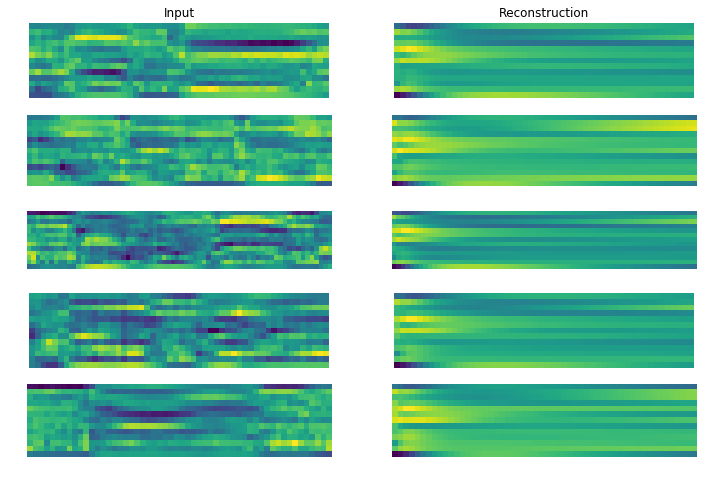

In [18]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

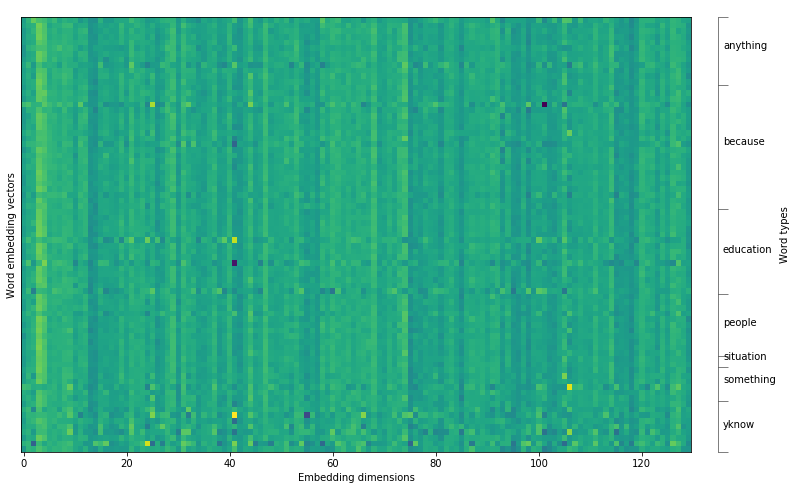

In [124]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )